In [1]:
# import necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OneHotEncoder

In [2]:
# read data
data_train = pd.read_csv('./train.csv', parse_dates=['host_since', 'first_review', 'last_review'])

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15696 entries, 0 to 15695
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   name                                          15696 non-null  object        
 1   description                                   15309 non-null  object        
 2   property_type                                 15696 non-null  object        
 3   price                                         15696 non-null  int64         
 4   neighbourhood_cleansed                        15696 non-null  object        
 5   neighbourhood_group_cleansed                  15696 non-null  object        
 6   latitude                                      15696 non-null  float64       
 7   longitude                                     15696 non-null  float64       
 8   host_since                                    15696 non-null  date

In [4]:
data_train.describe()

,price,latitude,longitude,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,calculated_host_listings_count,calculated_host_listings_count_entire_homes,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,15696.000000,15696.000000,15696.000000,15696,13493.000000,13643.000000,15696.000000,15696.000000,15696.000000,15696.000000,...,11222,11222,11222.000000,11222.000000,11222.000000,11222.00000,11222.000000,11221.000000,11222.000000,11222.000000
mean,2.465724,40.726899,-73.943147,2017-10-28 15:01:06.055045888,91.383013,78.579198,288.106588,393.435143,74.901631,45.303772,...,2021-02-06 17:41:35.170201344,2023-11-07 02:26:40.142577152,4.719393,4.742812,4.679642,4.82631,4.808233,4.721844,4.609505,1.245801
min,0.000000,40.500366,-74.251907,2008-08-11 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,2009-08-09 00:00:00,2011-12-10 00:00:00,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.010000
25%,1.000000,40.685686,-73.983133,2014-11-18 00:00:00,97.000000,69.000000,1.000000,2.000000,1.000000,0.000000,...,2019-04-10 06:00:00,2023-09-04 00:00:00,4.660000,4.690000,4.590000,4.81000,4.800000,4.630000,4.510000,0.210000
50%,2.000000,40.725251,-73.952458,2017-05-25 00:00:00,100.000000,91.000000,3.000000,5.000000,3.000000,1.000000,...,2022-04-12 00:00:00,2024-04-30 00:00:00,4.850000,4.880000,4.820000,4.94000,4.940000,4.820000,4.750000,0.610000
75%,4.000000,40.762314,-73.921120,2021-04-18 00:00:00,100.000000,100.000000,21.000000,31.000000,17.000000,4.000000,...,2023-05-31 00:00:00,2024-08-07 00:00:00,5.000000,5.000000,4.980000,5.00000,5.000000,5.000000,4.890000,1.650000
max,5.000000,40.911390,-73.713650,2024-08-31 00:00:00,100.000000,100.000000,4494.000000,9019.000000,876.000000,876.000000,...,2024-09-03 00:00:00,2024-09-04 00:00:00,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,110.100000
std,1.709624,0.058079,0.060149,NaN,22.320590,27.896484,984.327077,1205.427544,198.042132,166.432525,...,NaN,NaN,0.462927,0.460347,0.483314,0.37655,0.433165,0.400359,0.512808,2.269312


In [5]:
# process the data to values that can be examed
# this part is different from data cleaning later which is used for training

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
bool_imputer = SimpleImputer(strategy='most_frequent')
bool_imputer_2 = SimpleImputer(strategy='most_frequent')
str_imputer = SimpleImputer(strategy='constant', fill_value='None')

imputer_list = [num_imputer, bool_imputer, bool_imputer_2, str_imputer]

def preprocess_data(data_train, imputer_list, fit=False):

    # split the y
    y_exists = False
    if 'price' in data_train.columns:
        y = data_train[['price']] # y
        data_train.drop('price', axis=1, inplace=True)
        y_exists = True
    elif 'id' in data_train.columns:
        y = data_train[['id']] # y
        data_train.drop('id', axis=1, inplace=True)
        y_exists = True

    # we process the data by their dtype
    num_X = data_train.select_dtypes(include=['int64', 'float64'])
    bool_X = data_train.select_dtypes(include=['bool'])
    datetime_X = data_train.select_dtypes(include=['datetime64[ns]'])
    str_X = data_train.select_dtypes(include=['object'])
    
    # process numerical data
    if fit:
        num_X_imputed = num_imputer.fit_transform(num_X)
    else:
        num_X_imputed = num_imputer.transform(num_X)
    num_X = pd.DataFrame(num_X_imputed, columns=num_X.columns) # x
    
    # process boolean data
    if fit:
        bool_X_imputed = bool_imputer.fit_transform(bool_X.astype('int64'))
    else:
        bool_X_imputed = bool_imputer.transform(bool_X.astype('int64'))
    bool_X = pd.DataFrame(bool_X_imputed, columns=bool_X.columns) # x
    
    # process datetime data
    for col in datetime_X:
        datetime_X[f'{col}_year'] = datetime_X[col].dt.year.fillna(-1).astype('int64')
        datetime_X[f'{col}_month'] = datetime_X[col].dt.month.fillna(-1).astype('int64')
        datetime_X[f'{col}_day'] = datetime_X[col].dt.day.fillna(-1).astype('int64')
        datetime_X[f'{col}_hour'] = datetime_X[col].dt.hour.fillna(-1).astype('int64')
    datetime_X.drop(columns=['host_since', 'first_review', 'last_review'], inplace=True) # x
    
    # process string data
    # list object
    verify_X = str_X[['host_verifications']] # x
    str_X = str_X.drop('host_verifications', axis=1)
    # bool string object
    str_bool_X = str_X[['host_is_superhost', 'has_availability', 'has_availability']]
    str_X = str_X.drop(columns=['host_is_superhost', 'has_availability', 'has_availability'], axis=1)

    if fit:
        str_bool_X_imputed = bool_imputer_2.fit_transform(str_bool_X)
    else:
        str_bool_X_imputed = bool_imputer_2.fit_transform(str_bool_X)
    str_bool_X = pd.DataFrame(str_bool_X_imputed, columns=str_bool_X.columns).astype('int64') # x
    
    # rest of the objects
    if fit:
        str_X_imputed = str_imputer.fit_transform(str_X)
    else:
        str_X_imputed = str_imputer.transform(str_X)
    str_X = pd.DataFrame(str_X_imputed, columns=str_X.columns) # x
    str_X['reviews'] = str_X['reviews'].apply(lambda x: x.split("\n---------------------------------\n"))
    str_X['amenities'] = str_X['amenities'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').split(', '))

    if y_exists:
        X = pd.concat([y, num_X, bool_X, datetime_X, verify_X, str_bool_X, str_X], axis=1)
    else:
        X = pd.concat([num_X, bool_X, datetime_X, verify_X, str_bool_X, str_X], axis=1)

    return X
    
X = preprocess_data(data_train, imputer_list, True)

In [6]:
total_nan = X.isna().sum().sum()
print(f"Total number of NaN values: {total_nan}")

Total number of NaN values: 0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15696 entries, 0 to 15695
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   price                                         15696 non-null  int64  
 1   latitude                                      15696 non-null  float64
 2   longitude                                     15696 non-null  float64
 3   host_response_rate                            15696 non-null  float64
 4   host_acceptance_rate                          15696 non-null  float64
 5   host_listings_count                           15696 non-null  float64
 6   host_total_listings_count                     15696 non-null  float64
 7   calculated_host_listings_count                15696 non-null  float64
 8   calculated_host_listings_count_entire_homes   15696 non-null  float64
 9   calculated_host_listings_count_private_rooms  15696 non-null 

In [8]:
X.describe()

,price,latitude,longitude,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,first_review_month,first_review_day,first_review_hour,last_review_year,last_review_month,last_review_day,last_review_hour,host_is_superhost,has_availability,has_availability
count,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,...,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.0,15696.0
mean,2.465724,40.726899,-73.943147,91.383013,78.579198,288.106588,393.435143,74.901631,45.303772,27.702281,...,4.528033,10.746878,-0.285041,1446.276376,5.000127,10.806766,-0.285041,0.283894,1.0,1.0
std,1.709624,0.058079,0.060149,20.694893,26.008053,984.327077,1205.427544,198.042132,166.432525,117.504567,...,4.429388,10.888322,0.451448,913.857490,4.359272,11.265678,0.451448,0.450900,0.0,0.0
min,0.000000,40.500366,-74.251907,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.0,1.0
25%,1.000000,40.685686,-73.983133,91.383013,71.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.0,1.0
50%,2.000000,40.725251,-73.952458,100.000000,86.000000,3.000000,5.000000,3.000000,1.000000,1.000000,...,5.000000,9.000000,0.000000,2023.000000,7.000000,8.000000,0.000000,0.000000,1.0,1.0
75%,4.000000,40.762314,-73.921120,100.000000,100.000000,21.000000,31.000000,17.000000,4.000000,3.000000,...,8.000000,20.000000,0.000000,2024.000000,8.000000,21.000000,0.000000,1.000000,1.0,1.0
max,5.000000,40.911390,-73.713650,100.000000,100.000000,4494.000000,9019.000000,876.000000,876.000000,719.000000,...,12.000000,31.000000,0.000000,2024.000000,12.000000,31.000000,0.000000,1.000000,1.0,1.0


<Axes: >

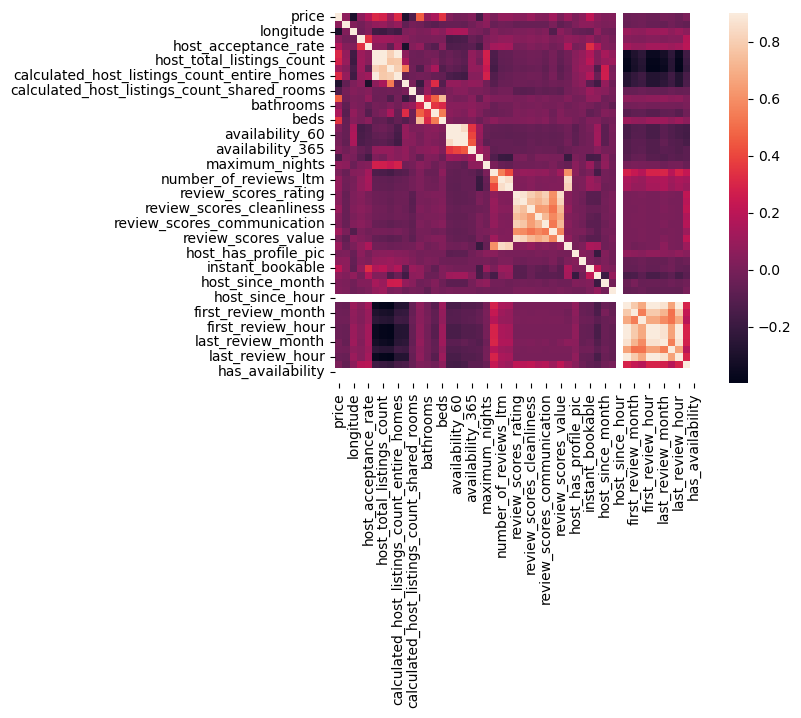

In [9]:
# heatmap of correlations of the numerical features

import seaborn as sns
temp_X = X.select_dtypes('number')


corrmat = temp_X.corr()
sns.heatmap(corrmat, vmax=0.9, square=True)


In [10]:
temp_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15696 entries, 0 to 15695
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   price                                         15696 non-null  int64  
 1   latitude                                      15696 non-null  float64
 2   longitude                                     15696 non-null  float64
 3   host_response_rate                            15696 non-null  float64
 4   host_acceptance_rate                          15696 non-null  float64
 5   host_listings_count                           15696 non-null  float64
 6   host_total_listings_count                     15696 non-null  float64
 7   calculated_host_listings_count                15696 non-null  float64
 8   calculated_host_listings_count_entire_homes   15696 non-null  float64
 9   calculated_host_listings_count_private_rooms  15696 non-null 

<Figure size 640x480 with 0 Axes>

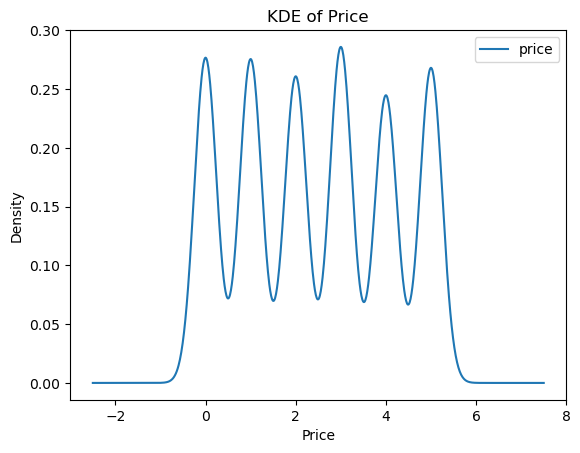

<Figure size 640x480 with 0 Axes>

In [11]:
# distribution of y

y_train = temp_X[['price']]
X_train = temp_X.drop('price', axis=1)

plt.clf()
y_train.plot(kind='kde')
plt.title('KDE of Price')
plt.xlabel('Price')
plt.show()
plt.clf()

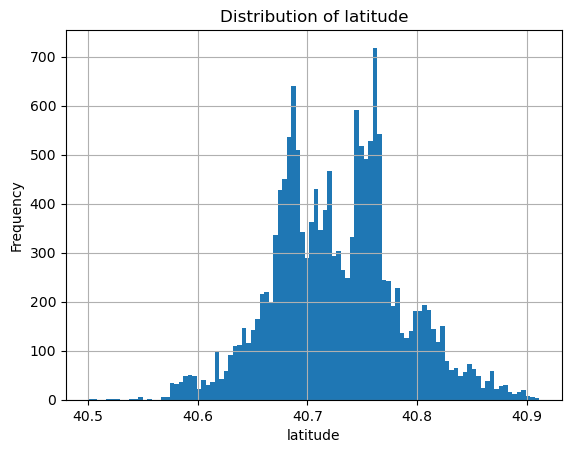

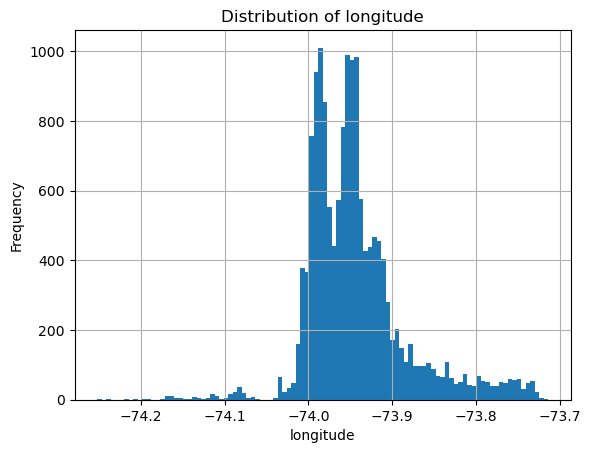

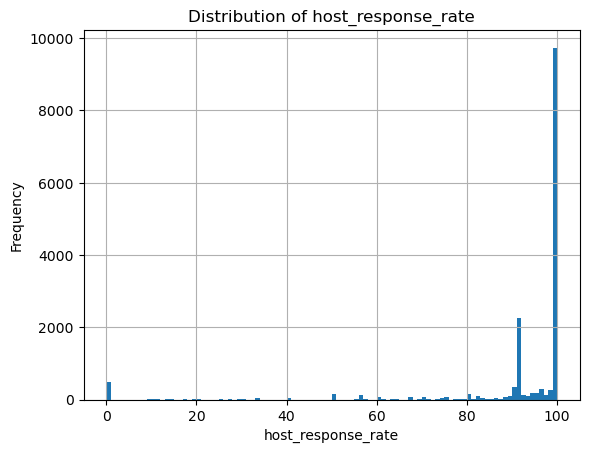

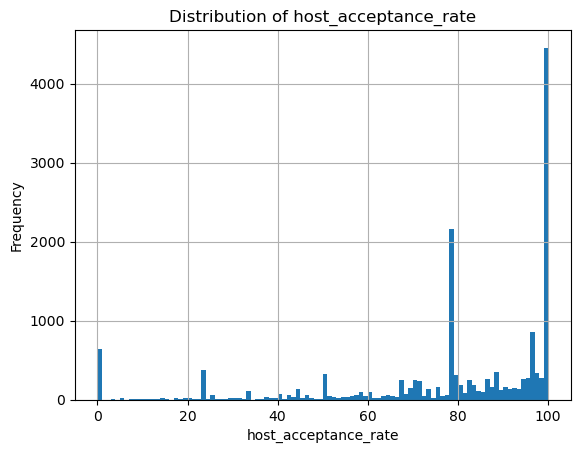

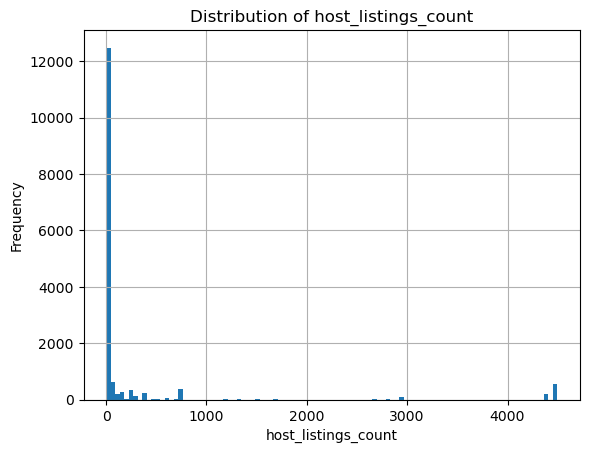

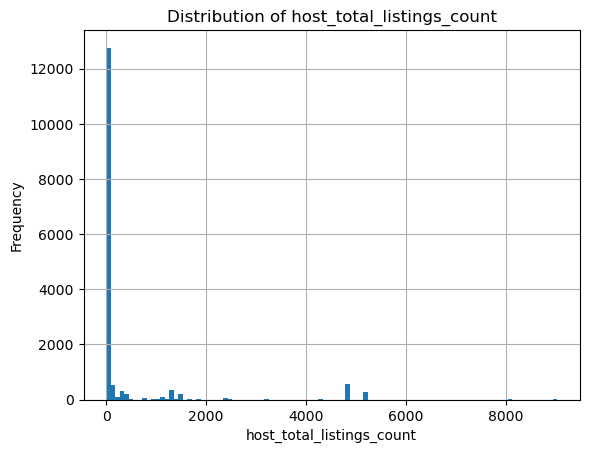

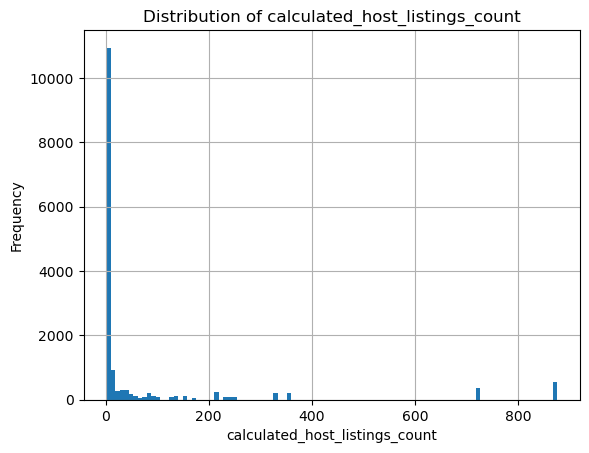

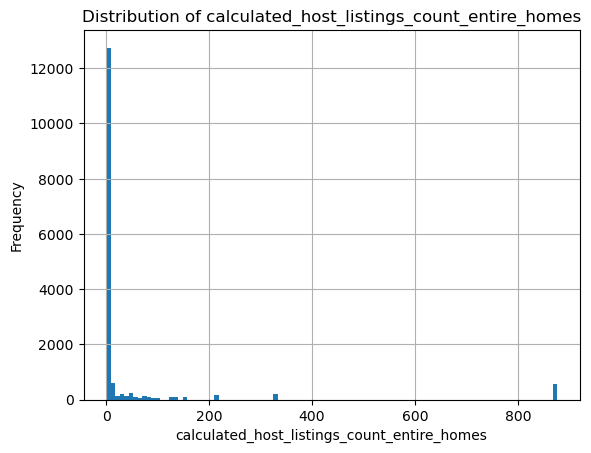

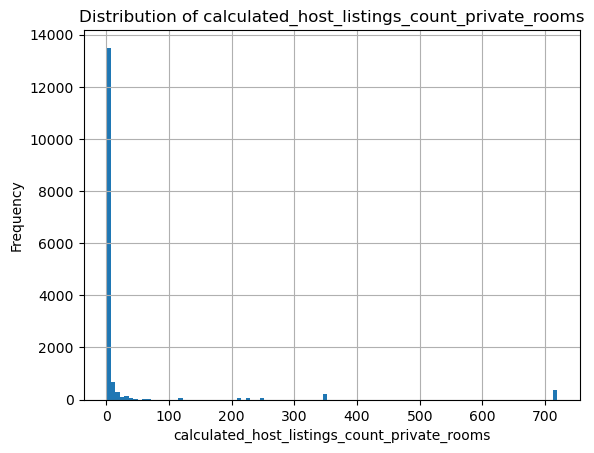

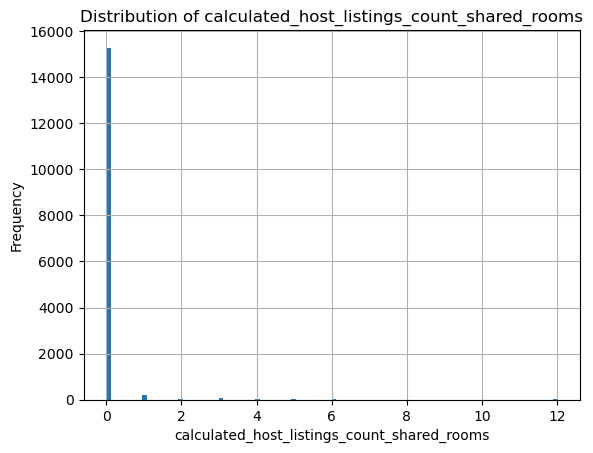

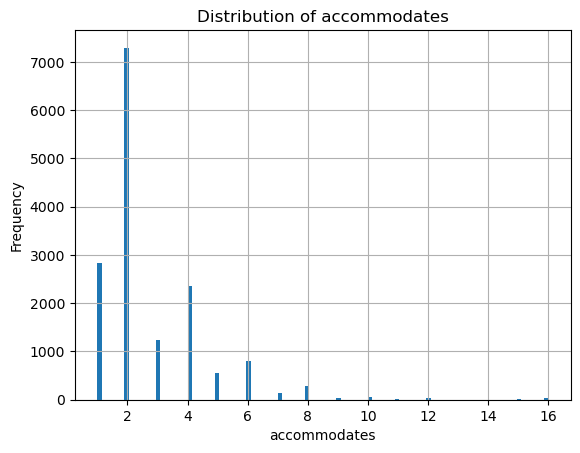

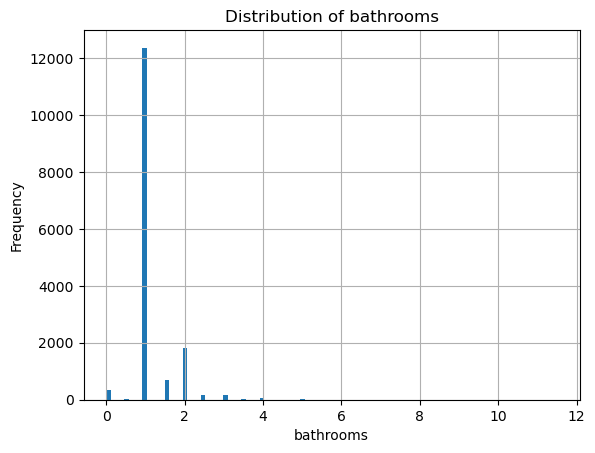

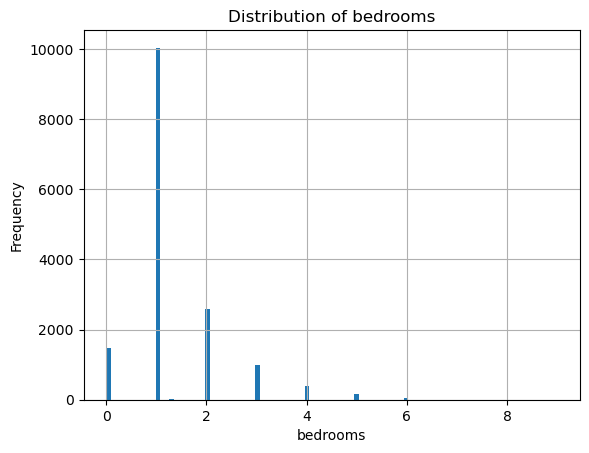

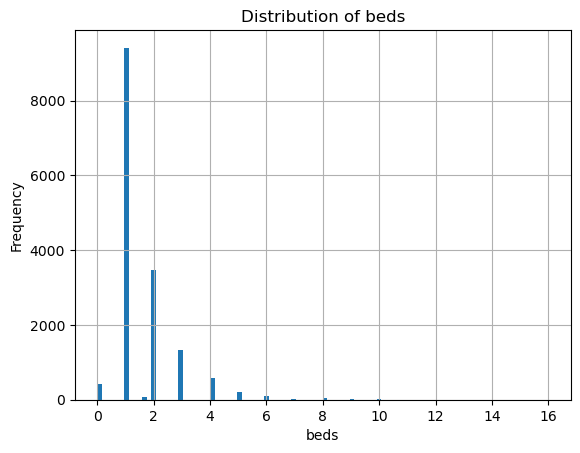

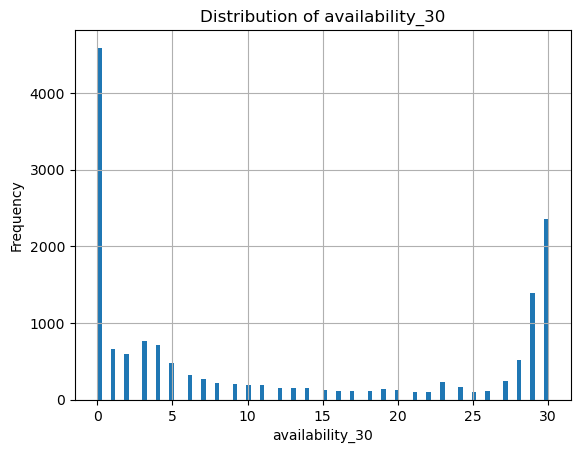

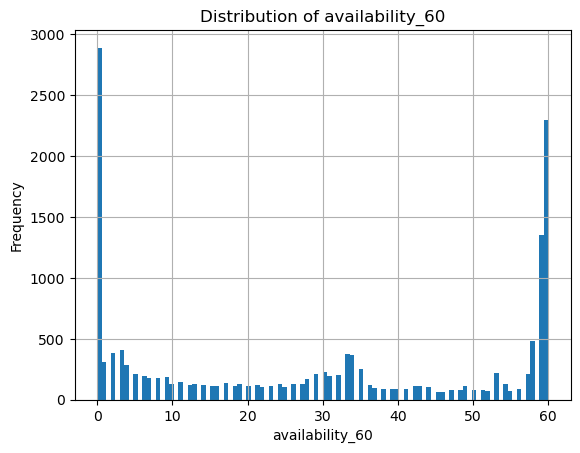

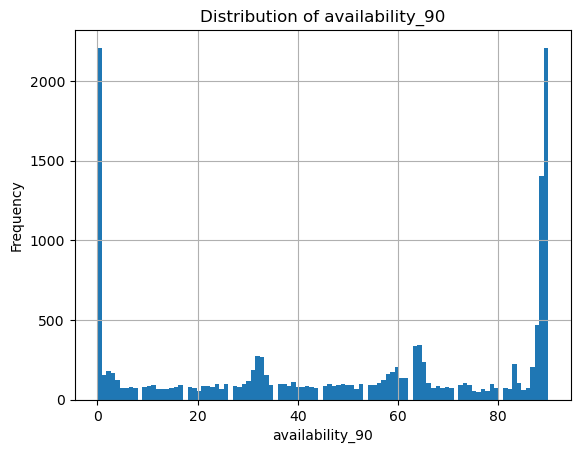

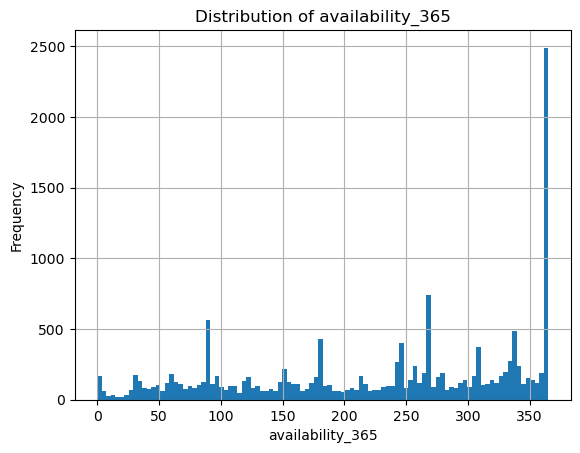

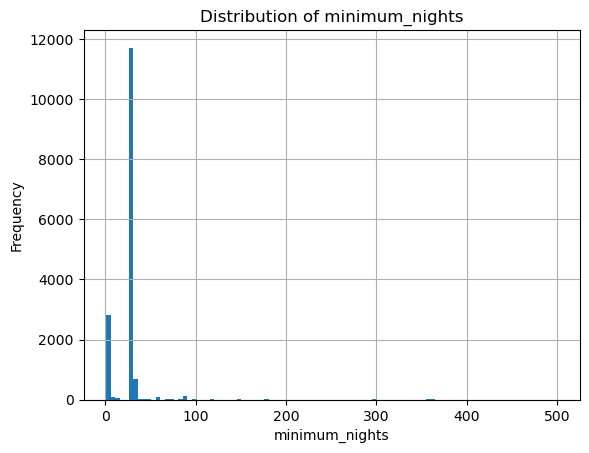

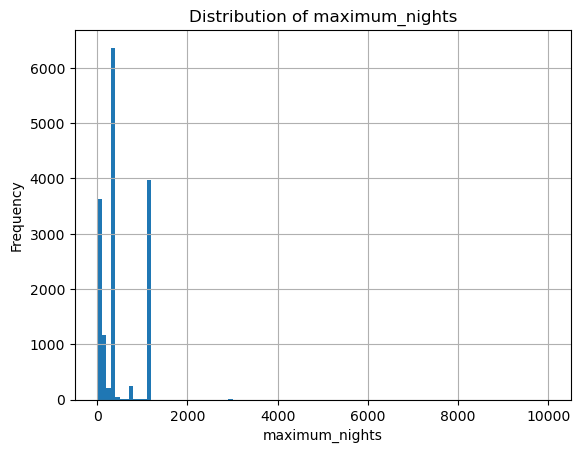

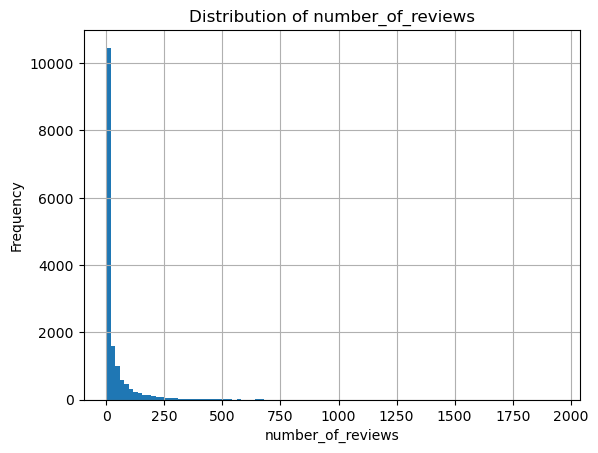

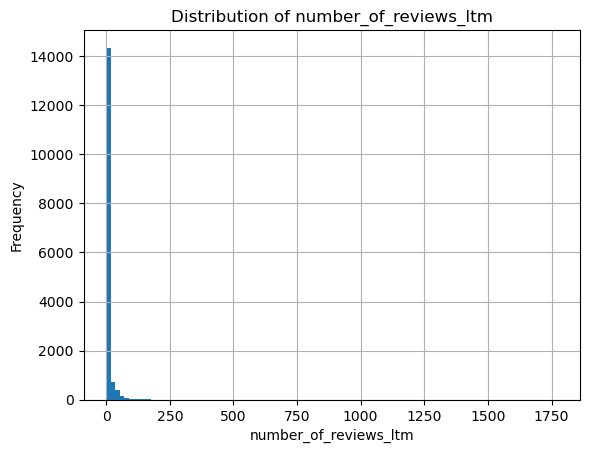

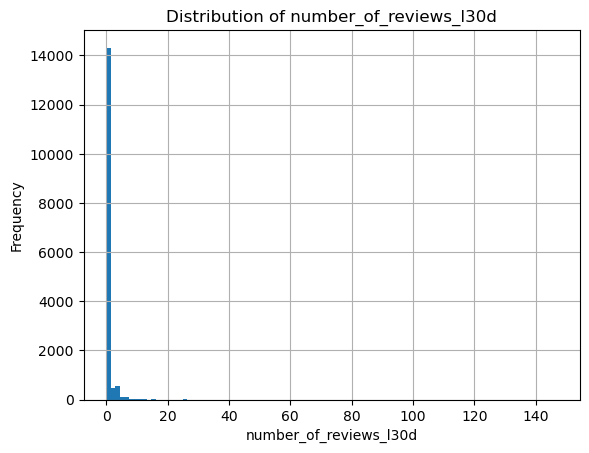

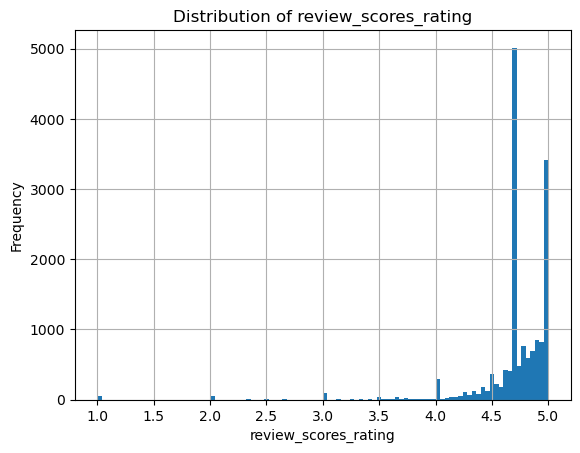

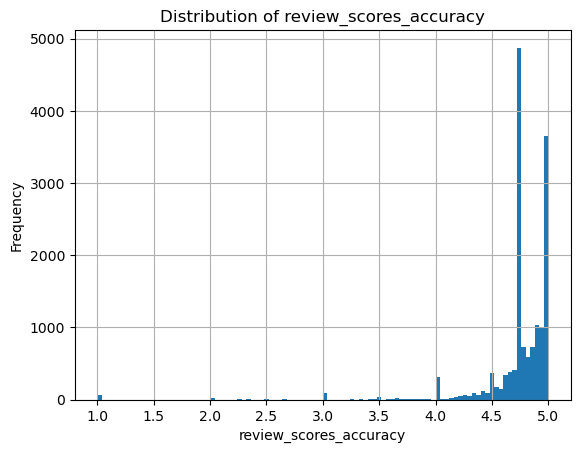

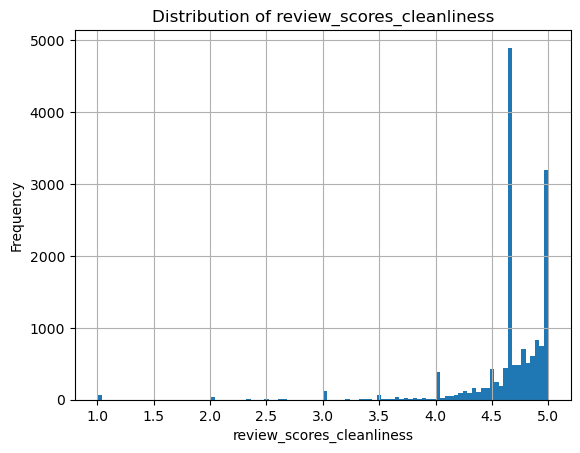

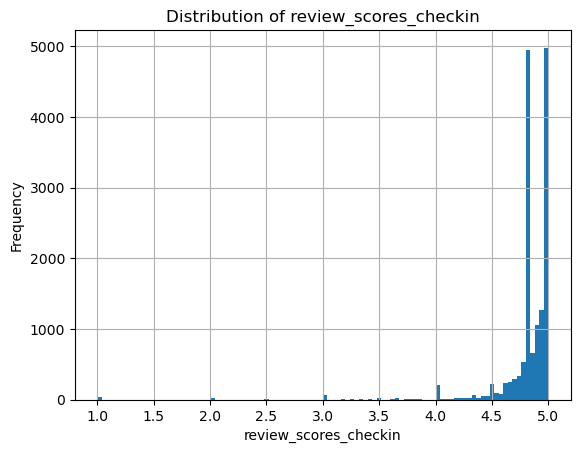

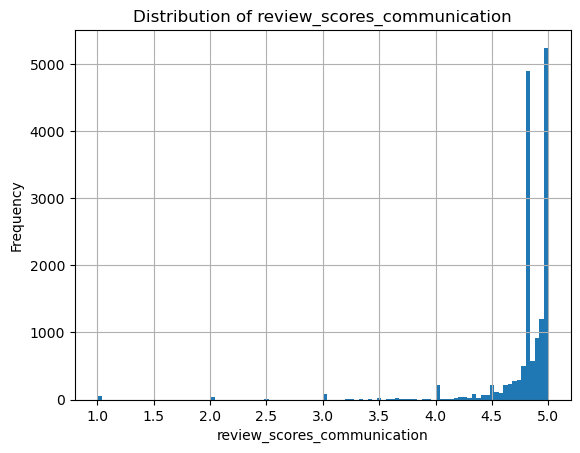

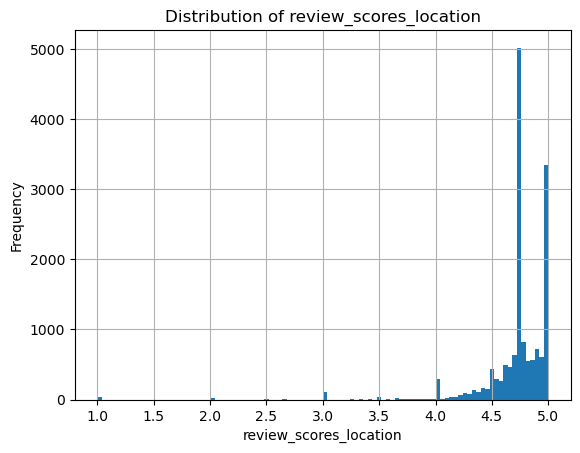

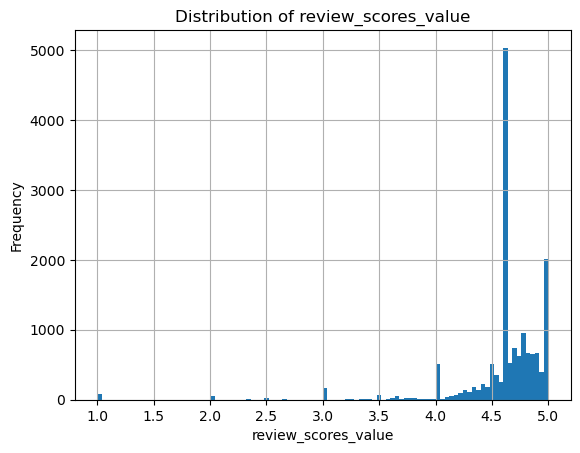

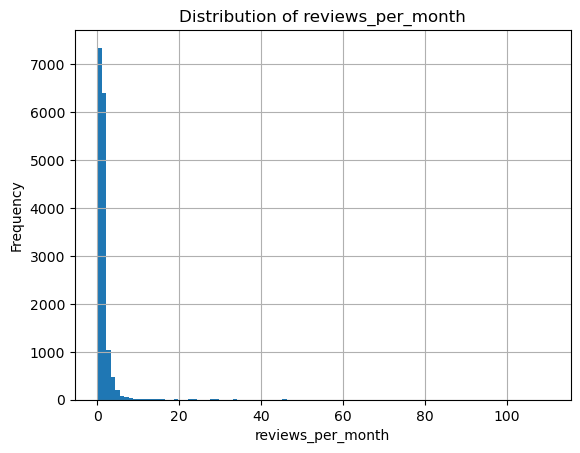

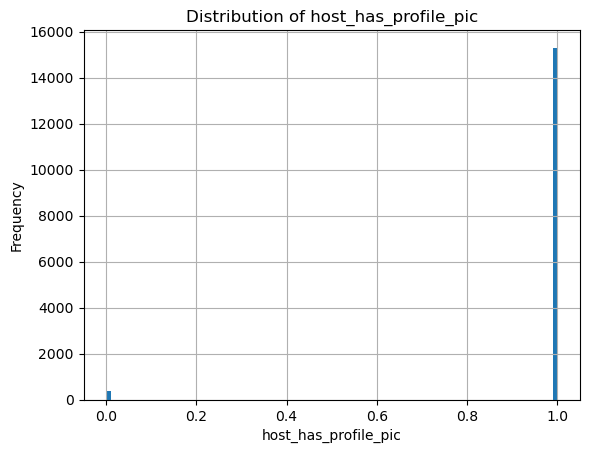

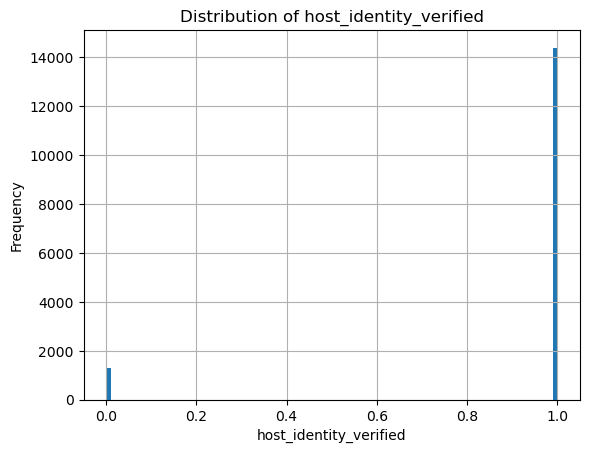

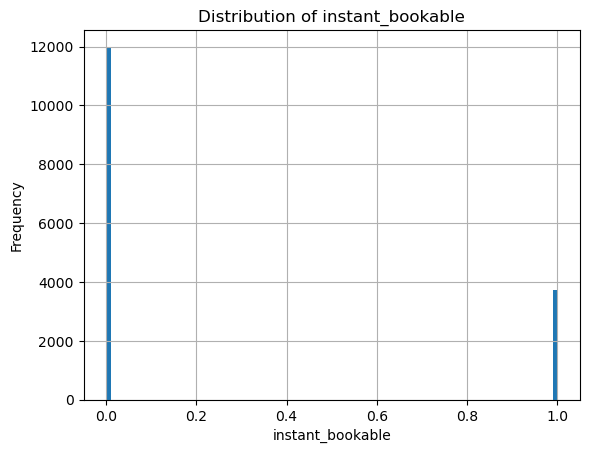

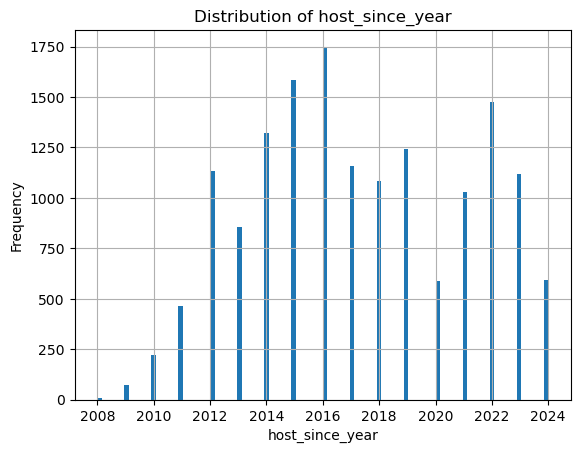

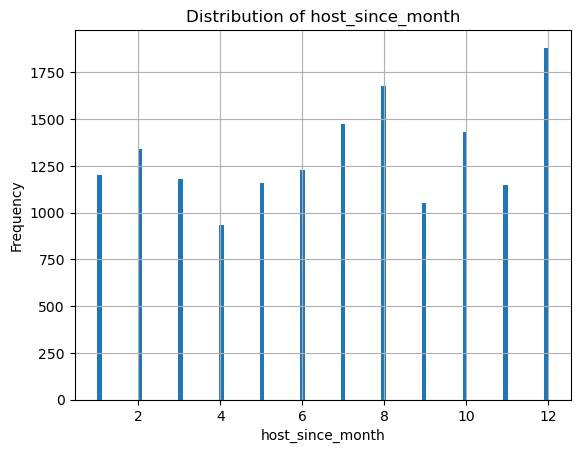

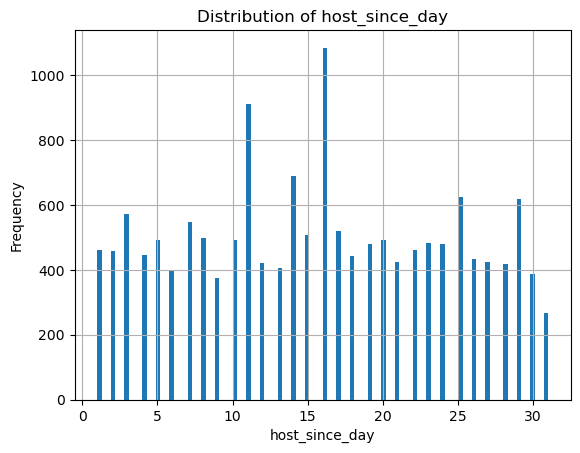

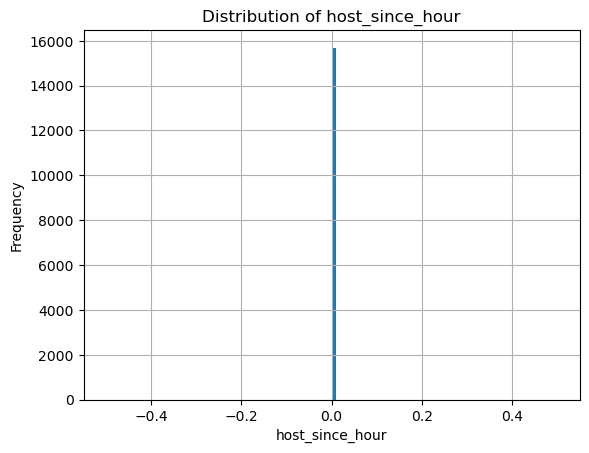

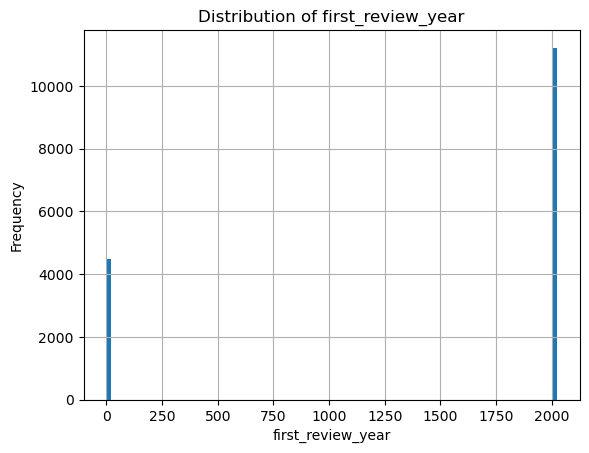

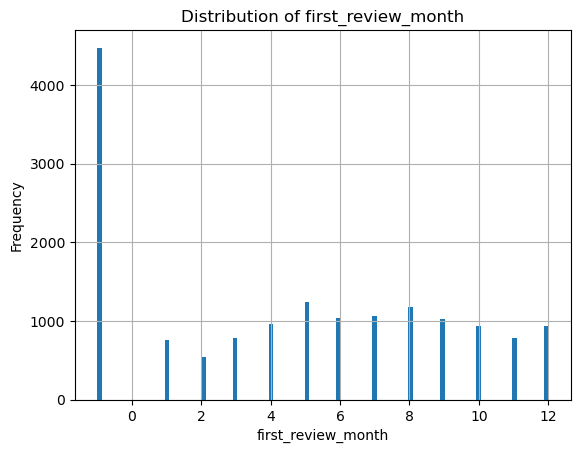

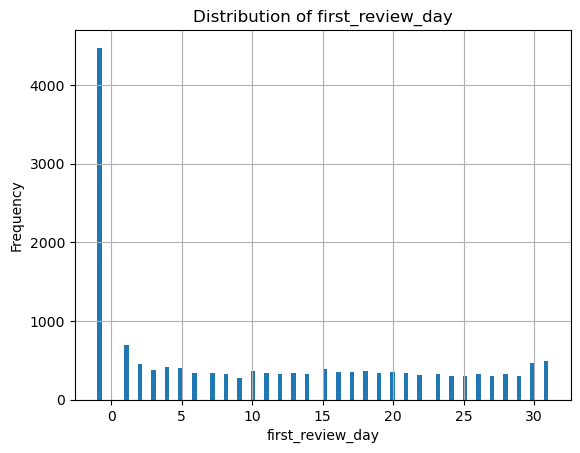

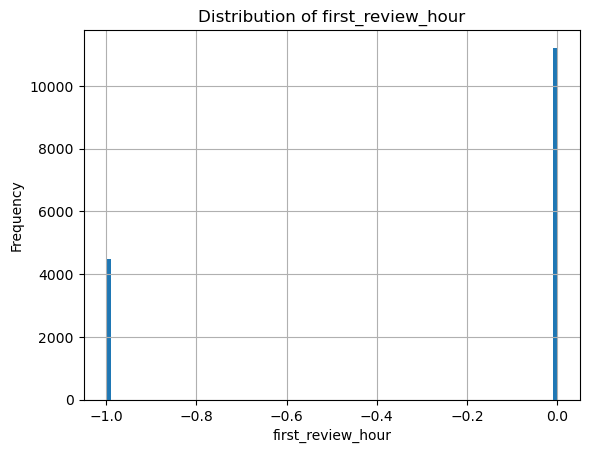

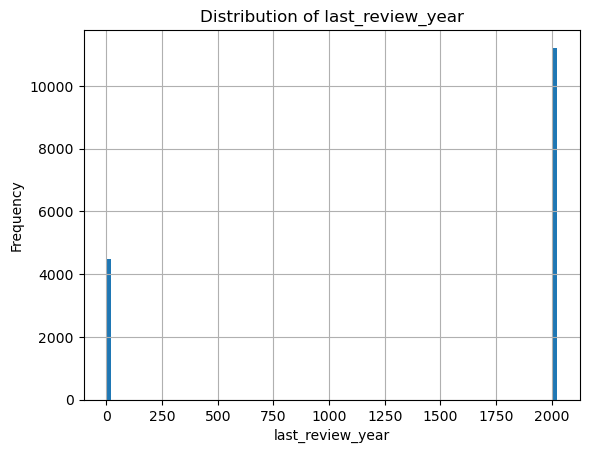

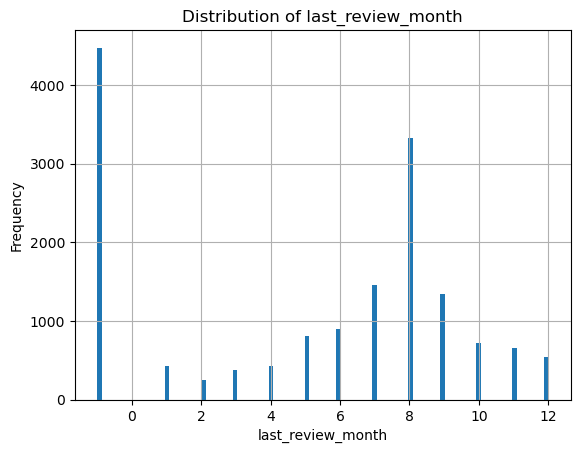

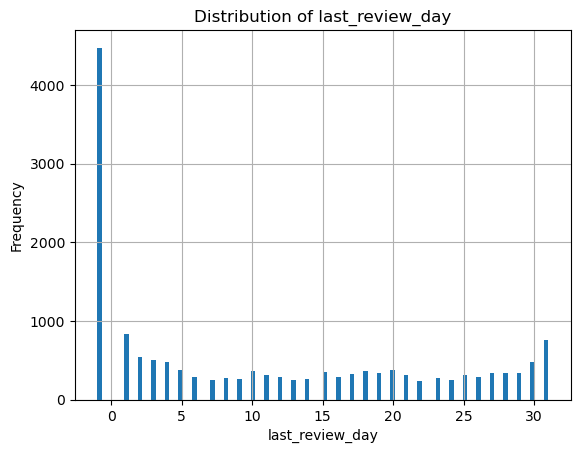

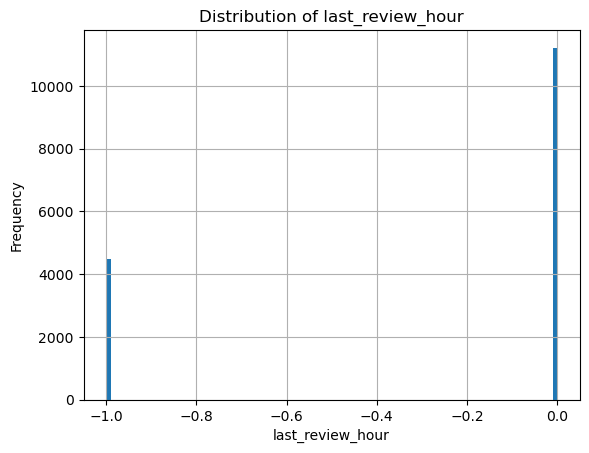

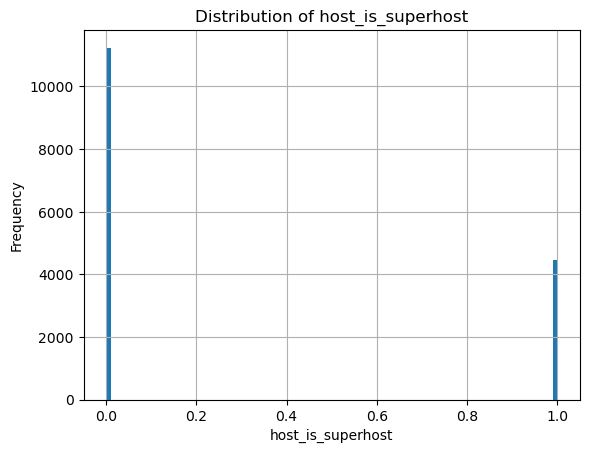

<Figure size 640x480 with 0 Axes>

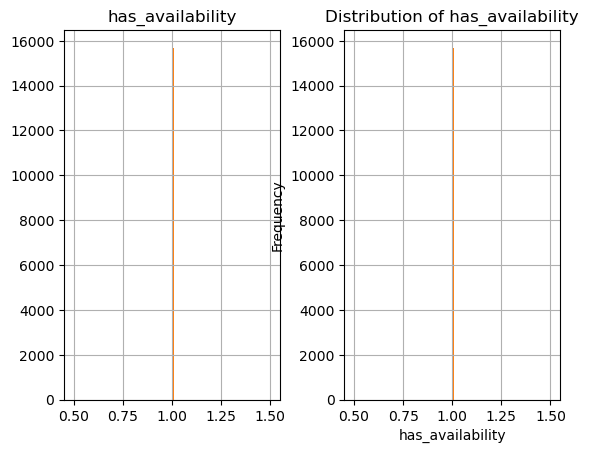

<Figure size 640x480 with 0 Axes>

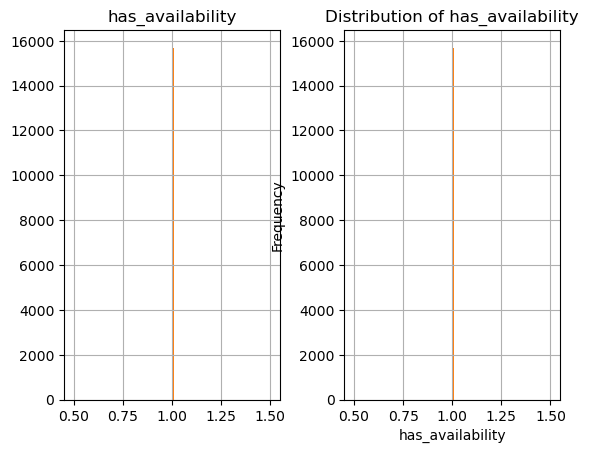

<Figure size 640x480 with 0 Axes>

In [12]:
# distribution of the features

for item in X_train.columns:
    plt.clf()
    X_train[item].hist(bins=100)
    plt.title(f'Distribution of {item}')
    plt.xlabel(item)
    plt.ylabel('Frequency')
    plt.show()
    plt.clf()

In [13]:
X_train

,latitude,longitude,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,...,first_review_month,first_review_day,first_review_hour,last_review_year,last_review_month,last_review_day,last_review_hour,host_is_superhost,has_availability,has_availability
0,40.684560,-73.939870,100.0,100.0,2.0,2.0,1.0,1.0,0.0,0.0,...,4,28,0,2024,8,10,0,1,1,1
1,40.638991,-73.965739,100.0,98.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1,13,0,2024,9,2,0,1,1,1
2,40.618810,-74.032380,100.0,100.0,52.0,55.0,52.0,50.0,2.0,0.0,...,6,27,0,2024,8,17,0,0,1,1
3,40.673970,-73.953990,99.0,23.0,727.0,1336.0,719.0,0.0,719.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0,1,1
4,40.747180,-73.985390,93.0,95.0,707.0,2453.0,73.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,40.704777,-74.006425,99.0,99.0,15.0,15.0,15.0,15.0,0.0,0.0,...,1,15,0,2024,8,14,0,1,1,1
15692,40.881490,-73.910130,100.0,67.0,2.0,2.0,2.0,0.0,2.0,0.0,...,4,16,0,2023,11,18,0,0,1,1
15693,40.765440,-73.976508,100.0,98.0,28.0,35.0,16.0,10.0,6.0,0.0,...,8,21,0,2023,8,21,0,1,1,1
15694,40.735635,-74.005740,100.0,96.0,4494.0,4784.0,876.0,876.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0,1,1


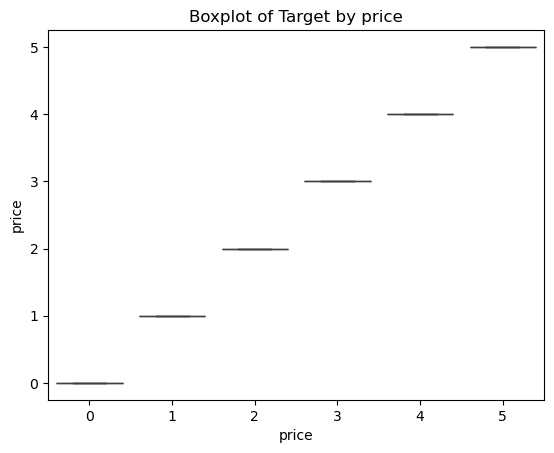

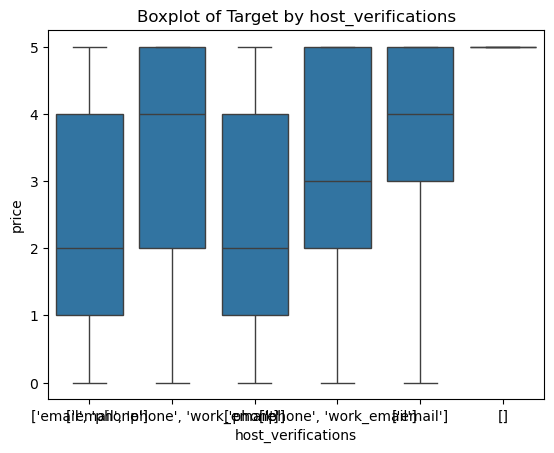

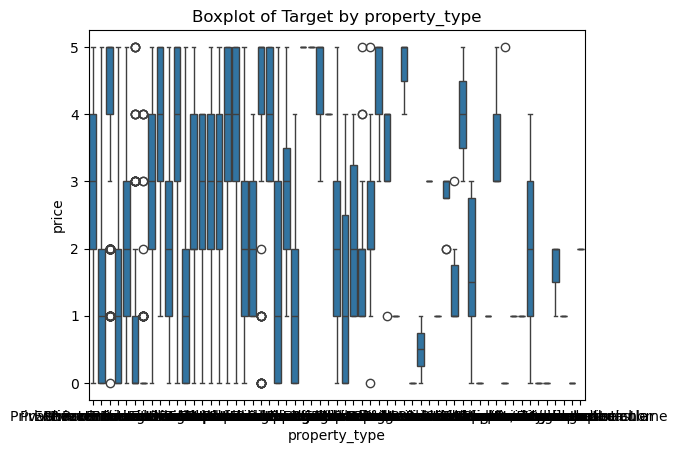

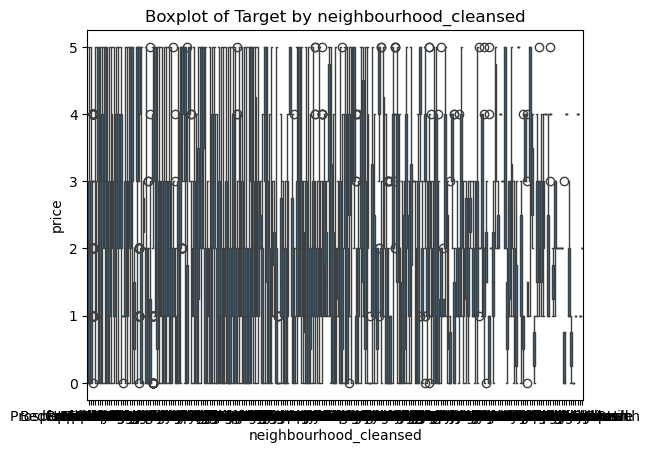

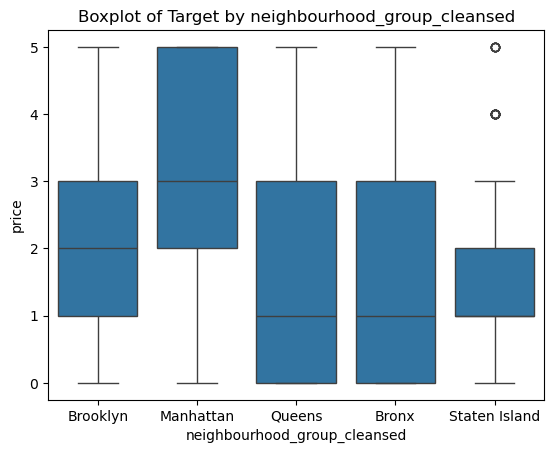

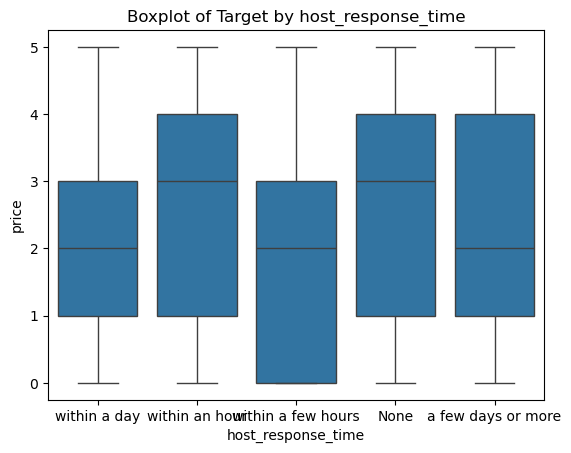

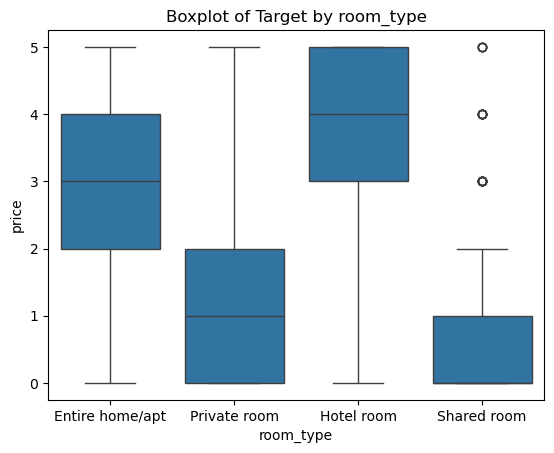

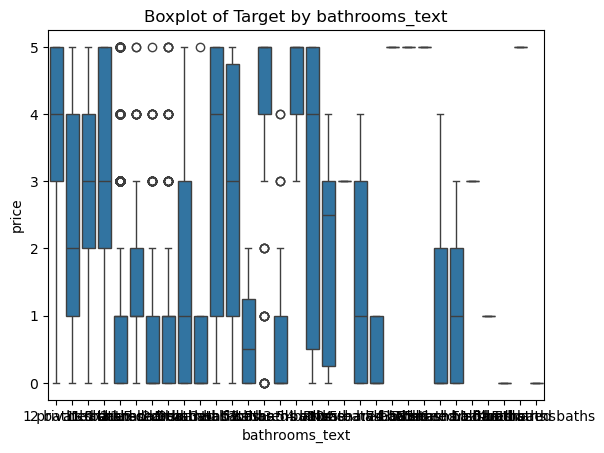

In [14]:
# exam categorical data

obj = X.select_dtypes('object')
amenities = obj.drop('amenities', axis=1)
obj.drop(columns=['name', 'description', 'reviews', 'amenities'], inplace=True)
obj = pd.concat([y_train, obj], axis=1)

for item in obj.columns:
    plt.clf()
    sns.boxplot(x=item, y='price', data=obj)
    plt.title(f'Boxplot of Target by {item}')
    plt.show()

In [15]:
# one hot encode the categorical data

obj.drop('price', axis=1, inplace=True)
encoded = pd.get_dummies(obj)
encoded

,"host_verifications_['email', 'phone', 'work_email']","host_verifications_['email', 'phone']",host_verifications_['email'],"host_verifications_['phone', 'work_email']",host_verifications_['phone'],host_verifications_[],property_type_Boat,property_type_Camper/RV,property_type_Casa particular,property_type_Entire bungalow,...,bathrooms_text_5 baths,bathrooms_text_5 shared baths,bathrooms_text_5.5 baths,bathrooms_text_6 baths,bathrooms_text_6 shared baths,bathrooms_text_7 baths,bathrooms_text_Half-bath,bathrooms_text_None,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15692,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15693,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15694,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# exam the mutual info scores

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
mi_scores = mutual_info_regression(pd.get_dummies(obj), X['price'])

print(f"Mutual Information Score: {mi_scores}")

Mutual Information Score: [2.02832315e-02 6.77449778e-03 1.91418333e-03 9.36881579e-03
 1.29482241e-03 4.52118839e-03 1.54347522e-03 0.00000000e+00
 0.00000000e+00 4.19348293e-03 1.13651907e-02 2.78554797e-03
 9.80369524e-03 1.18767563e-02 5.63327347e-03 9.48790759e-03
 6.20293725e-03 1.11282272e-01 0.00000000e+00 1.30578990e-02
 1.21479279e-03 6.81115090e-03 0.00000000e+00 1.02597476e-02
 4.90614082e-03 3.60405592e-03 2.35004391e-04 8.56663733e-03
 7.18839093e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.38136320e-03 0.00000000e+00 3.02930238e-02 4.34433418e-03
 0.00000000e+00 4.14782072e-03 1.12046499e-02 0.00000000e+00
 9.61578240e-03 1.21264624e-01 2.21861889e-03 0.00000000e+00
 2.74043402e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.76388101e-03 1.44900289e-02
 0.00000000e+00 5.99134702e-03 0.00000000e+00 6.60184322e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.50568569e-03 0.00000000e+00 1.25389478e-03 1.40219081e-0

In [17]:
# create a list for categorical dat of which the mutual info score is low and can possibily be dropped

assert mi_scores.shape[0] == len(encoded.columns.tolist())

encoded_feature_names = encoded.columns.tolist()
mi_df = pd.DataFrame({'Feature': encoded_feature_names, 'Score': mi_scores})

epsilon = 1e-04

low_score_obj_features = mi_df[mi_df['Score'] < epsilon]['Feature'].tolist()
print((low_score_obj_features))

['property_type_Camper/RV', 'property_type_Casa particular', 'property_type_Entire serviced apartment', 'property_type_Houseboat', 'property_type_Private room in condo', 'property_type_Private room in cottage', 'property_type_Private room in earthen home', 'property_type_Private room in guesthouse', 'property_type_Private room in houseboat', 'property_type_Private room in ranch', 'property_type_Private room in serviced apartment', 'property_type_Private room in tower', 'property_type_Private room in townhouse', 'property_type_Private room in vacation home', 'property_type_Private room in villa', 'property_type_Room in aparthotel', 'property_type_Room in serviced apartment', 'property_type_Shared room in casa particular', 'property_type_Shared room in guest suite', 'property_type_Shared room in guesthouse', 'property_type_Shared room in home', 'property_type_Shared room in hostel', 'property_type_Shared room in serviced apartment', 'neighbourhood_cleansed_Arrochar', 'neighbourhood_clean

In [18]:
# the correlation of numerical data with price
# we believe the features in num_drop_list has low intuitive relationship with price

num_drop_list = ['host_since_hour', 'has_availability', 'has_availability']
temp_X.drop(columns=num_drop_list, inplace=True)
temp_X
cor = temp_X.corr()['price']
cor

price                                           1.000000
latitude                                        0.059409
longitude                                      -0.291887
host_response_rate                              0.056749
host_acceptance_rate                            0.172775
host_listings_count                             0.310123
host_total_listings_count                       0.286618
calculated_host_listings_count                  0.104923
calculated_host_listings_count_entire_homes     0.317481
calculated_host_listings_count_private_rooms   -0.283525
calculated_host_listings_count_shared_rooms    -0.126215
accommodates                                    0.461269
bathrooms                                       0.076518
bedrooms                                        0.149270
beds                                            0.344459
availability_30                                 0.030267
availability_60                                -0.014047
availability_90                

In [19]:
print(len(temp_X.columns.tolist()))
print(len(cor))

47
47


In [20]:
# we put features that have low correlation with price in to a list in which feature could be dropped

cor_df = pd.DataFrame({'Feature': temp_X.columns.tolist(), 'Score': cor})

epsilon = 0.01

low_score_num_features = cor_df[abs(cor_df['Score']) < epsilon]['Feature'].tolist()
print((low_score_num_features))

['availability_90', 'number_of_reviews', 'review_scores_value', 'host_is_superhost']


In [21]:
# merge the list
low_score_num_features += num_drop_list

In [22]:
# encode the amenities feature

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_amenities = mlb.fit_transform(X['amenities'].copy())
encoded_amenities_df = pd.DataFrame(encoded_amenities, columns=mlb.classes_, index=X['amenities'].copy().index)
encoded_amenities_df

,,Bertazzoni stainless steel oven,Bodywash body soap,Bowers & Wilkins sound system,Eco Botanics Travel Size conditioner,Eco Botanics Travel Size shampoo,Eco Botanics Travel Size body soap,Eco Botanics Travel Size conditioner,Eco Botanics Travel Size shampoo,Eco Botanics body soap,...,treadmill,tress\u00e9 conditioner,undercounter refrigerator,variants of body\u2019s washes body soap,wardrobe,wifi connect sound system,with small freezer. refrigerator,wood-burning,workout bench,yoga mat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# exam the mutual info score for new features generated from amenities

a_mi_scores = mutual_info_regression(encoded_amenities_df, X['price'])

print(f"Mutual Information Score: {a_mi_scores}")

Mutual Information Score: [0.         0.01217934 0.         ... 0.         0.00092242 0.00363228]


In [24]:
# we put amenities features that have low correlation with price in to a list in which feature could be dropped

assert a_mi_scores.shape[0] == len(encoded_amenities_df.columns.tolist())

encoded_amenities_feature_names = encoded_amenities_df.columns.tolist()
a_mi_df = pd.DataFrame({'Feature': encoded_amenities_feature_names, 'Score': a_mi_scores})

epsilon = 0.01

low_score_amenities_features = a_mi_df[a_mi_df['Score'] < epsilon]['Feature'].tolist()
print(len(low_score_amenities_features))
# print((low_score_amenities_features))

3362


In [25]:
# merge all numerical and categorical data that could be dropped due to low score
additional_list = ['host_listings_count']
final_drop_list = low_score_num_features + low_score_obj_features + low_score_amenities_features + additional_list


In [30]:
# re-read the data and use them for first level training
# first level training is basically to see if dropping features with low scores and adding intersections
# or other features will enhance the performance
from sklearn.cluster import KMeans
import sys

data_train = pd.read_csv('./train.csv', parse_dates=['host_since', 'first_review', 'last_review'])
data_train.drop(columns=['name', 'description', 'reviews'], axis=1, inplace=True)
y_train = data_train[['price']]
data_train.drop('price', axis=1, inplace=True)


data_test = pd.read_csv('./test.csv', parse_dates=['host_since', 'first_review', 'last_review'])
data_test.drop(columns=['name', 'description', 'reviews'], axis=1, inplace=True)
ID = data_test['id'].values
data_test.drop('id', axis=1, inplace=True)

df = pd.concat([data_train, data_test], axis=0)



datetime_X = df.select_dtypes(include=['datetime64[ns]'])

for col in datetime_X:
    datetime_X[f'{col}_year'] = datetime_X[col].dt.year.fillna(-1).astype('int64')
    datetime_X[f'{col}_month'] = datetime_X[col].dt.month.fillna(-1).astype('int64')
    datetime_X[f'{col}_day'] = datetime_X[col].dt.day.fillna(-1).astype('int64')
    datetime_X[f'{col}_hour'] = datetime_X[col].dt.hour.fillna(-1).astype('int64')
datetime_X.drop(columns=['host_since', 'first_review', 'last_review'], inplace=True)
df.drop(columns=['host_since', 'first_review', 'last_review'], inplace=True)





df['amenities'] = df['amenities'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').split(', '))


df['reviews_total'] = df['number_of_reviews'] * df['review_scores_rating']
df['min_nights_availability'] = df['minimum_nights'] / (df['availability_365']+1)
df['max_nights_availability'] = df['maximum_nights'] / (df['availability_365']+1)
df['reviews_with_day'] = df['number_of_reviews'] / (df['availability_365']+1)
df['accuracy_value'] = df['review_scores_accuracy'] * (df['review_scores_value'])
df['total_host_listings'] = (
    df['calculated_host_listings_count_entire_homes'] +
    df['calculated_host_listings_count_private_rooms'] +
    df['calculated_host_listings_count_shared_rooms']
)

kmeans = KMeans(n_clusters=100, random_state=42)
df['region'] = kmeans.fit_predict(df[['latitude', 'longitude']])

df['availability_mean'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)

df['review_scores_std'] = df[['review_scores_accuracy', 'review_scores_cleanliness', 
                              'review_scores_checkin', 'review_scores_communication', 
                              'review_scores_location', 'review_scores_value']].std(axis=1)

df['bedroom_bathroom_ratio'] = df['bedrooms'] / (df['bathrooms']+1)

df['bed_bedroom_ratio'] = df['beds'] / (df['bedrooms'] + 1)


numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns


mlb = MultiLabelBinarizer()
encoded_amenities = mlb.fit_transform(df['amenities'].copy())
encoded_amenities_df = pd.DataFrame(encoded_amenities, columns=mlb.classes_, index=df['amenities'].copy().index)
df.drop('amenities', axis=1, inplace=True)





df = pd.concat([df, datetime_X], axis=1)

obj_X = df.select_dtypes(include=['object'])
df.drop(columns=obj_X.columns, axis=1, inplace=True)
obj_X = pd.get_dummies(obj_X)

df = pd.concat([df, obj_X, encoded_amenities_df], axis=1)


common_items = list(set(final_drop_list) & set(df.columns.tolist()))
df.drop(columns=common_items, axis=1, inplace=True)
df.columns = df.columns.str.replace(r'[\[\],<>]', '', regex=True)

data_train = df[:len(data_train)]
data_train_cv = data_train.copy()
data_test = df[len(data_train):]

We use both grid search and simple train-validation split to train the model. For details please see hyperparameter selection in report.

In [29]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgb_model = XGBRegressor(random_state=42)



# possible set of hyper parameters

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 5, 7, 9, 11],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 1, 2, 3, 4, 5],
#     'reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# }


# param_grid = {
#     'n_estimators': [250, 300, 350, 400],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [7, 9],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0],
#     'reg_alpha': [0, 0.2, 1],
#     'reg_lambda': [0, 0.2, 1]
# }

param_grid = {
    'n_estimators': [450],
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [0]
}


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(data_train_cv, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rmse = (-grid_search.best_score_)**0.5
print(f"Best RMSE: {best_rmse:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
Best RMSE: 0.7209


In [31]:
X_train, X_val, y_train, y_val = train_test_split(data_train_cv, y_train, random_state=42, test_size=0.25, shuffle=True)

xgbr = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1, gamma=0, reg_alpha=1, reg_lambda=0)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)


from sklearn.metrics import root_mean_squared_error


print(root_mean_squared_error(y_pred, y_val))
print(root_mean_squared_error(np.round(y_pred).astype(int), y_val))

0.7173731034547416
0.7625938888737599


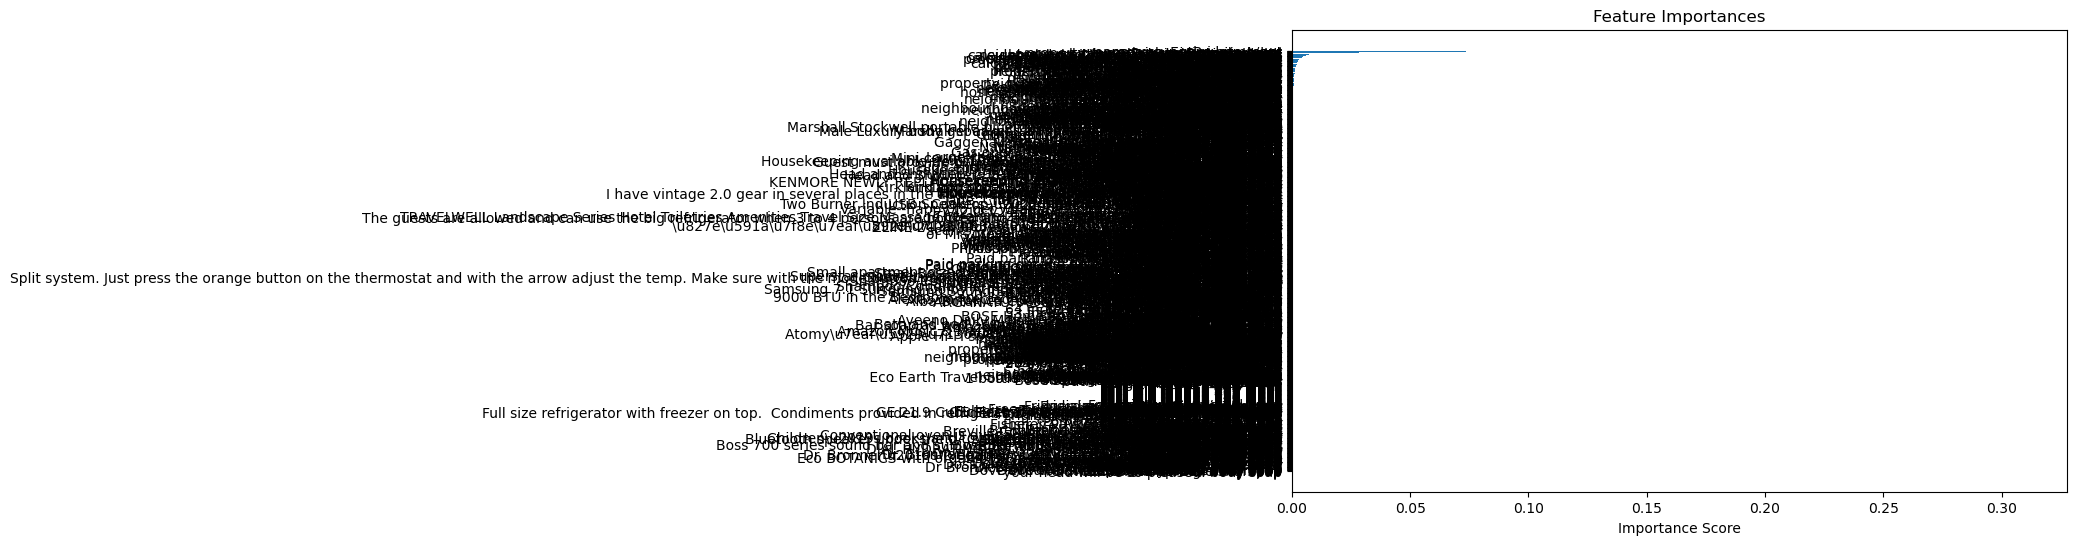

In [32]:
# exam the feature importance

importances = xgbr.feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.show()

In [33]:
feature_importances

,feature,importance
230,room_type_Entire home/apt,0.311914
231,room_type_Private room,0.236202
19,minimum_nights,0.073627
81,property_type_Room in hotel,0.030899
78,property_type_Private room in resort,0.030489
...,...,...
562,Dove cucumber melon body wash body soap,0.000000
561,Dove and or Dial body soap,0.000000
560,Dove and Pantene shampoo,0.000000
559,Dove and Irish spring body soap,0.000000


In [34]:
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()

# Select features contributing to 95% of total importance
selected_features = feature_importances[feature_importances['cumulative_importance'] <= 0.95]['feature']
print("Selected Features:", selected_features.tolist())
print(len(selected_features.tolist()))

Selected Features: ['room_type_Entire home/apt', 'room_type_Private room', 'minimum_nights', 'property_type_Room in hotel', 'property_type_Private room in resort', 'property_type_Room in boutique hotel', 'bathrooms_text_1 shared bath', 'accommodates', 'bathrooms', 'calculated_host_listings_count_shared_rooms', 'neighbourhood_group_cleansed_Manhattan', 'Lock on bedroom door', 'Dishwasher', 'neighbourhood_cleansed_Fort Hamilton', 'bedrooms', 'host_total_listings_count', 'Crib', 'neighbourhood_cleansed_Edgemere', 'Elevator', 'calculated_host_listings_count_private_rooms', 'neighbourhood_cleansed_Upper East Side', 'neighbourhood_cleansed_Theater District', 'calculated_host_listings_count', 'property_type_Private room in casa particular', 'longitude', 'neighbourhood_cleansed_Far Rockaway', 'bathrooms_text_1 bath', 'availability_60', 'bed_bedroom_ratio', 'neighbourhood_cleansed_Castle Hill', 'Gym', 'neighbourhood_cleansed_Bay Ridge', 'min_nights_availability', 'City skyline view', 'last_revi

In [37]:
# second level traing
# this is for hyperparameter tuning and final predicting
from sklearn.cluster import KMeans
import sys

data_train = pd.read_csv('./train.csv', parse_dates=['host_since', 'first_review', 'last_review'])
data_train.drop(columns=['name', 'description', 'reviews'], axis=1, inplace=True)
y_train = data_train[['price']]
data_train.drop('price', axis=1, inplace=True)


data_test = pd.read_csv('./test.csv', parse_dates=['host_since', 'first_review', 'last_review'])
data_test.drop(columns=['name', 'description', 'reviews'], axis=1, inplace=True)
ID = data_test['id'].values
data_test.drop('id', axis=1, inplace=True)

df = pd.concat([data_train, data_test], axis=0)



datetime_X = df.select_dtypes(include=['datetime64[ns]'])

for col in datetime_X:
    datetime_X[f'{col}_year'] = datetime_X[col].dt.year.fillna(-1).astype('int64')
    datetime_X[f'{col}_month'] = datetime_X[col].dt.month.fillna(-1).astype('int64')
    datetime_X[f'{col}_day'] = datetime_X[col].dt.day.fillna(-1).astype('int64')
    datetime_X[f'{col}_hour'] = datetime_X[col].dt.hour.fillna(-1).astype('int64')
datetime_X.drop(columns=['host_since', 'first_review', 'last_review'], inplace=True)
df.drop(columns=['host_since', 'first_review', 'last_review'], inplace=True)





df['amenities'] = df['amenities'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').split(', '))


df['reviews_total'] = df['number_of_reviews'] * df['review_scores_rating']
df['min_nights_availability'] = df['minimum_nights'] / (df['availability_365']+1)
df['max_nights_availability'] = df['maximum_nights'] / (df['availability_365']+1)
df['reviews_with_day'] = df['number_of_reviews'] / (df['availability_365']+1)
df['accuracy_value'] = df['review_scores_accuracy'] * (df['review_scores_value'])
df['total_host_listings'] = (
    df['calculated_host_listings_count_entire_homes'] +
    df['calculated_host_listings_count_private_rooms'] +
    df['calculated_host_listings_count_shared_rooms']
)

kmeans = KMeans(n_clusters=100, random_state=42)
df['region'] = kmeans.fit_predict(df[['latitude', 'longitude']])

df['availability_mean'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)

df['review_scores_std'] = df[['review_scores_accuracy', 'review_scores_cleanliness', 
                              'review_scores_checkin', 'review_scores_communication', 
                              'review_scores_location', 'review_scores_value']].std(axis=1)

df['bedroom_bathroom_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1)

df['bed_bedroom_ratio'] = df['beds'] / (df['bedrooms'] + 1)


numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns


mlb = MultiLabelBinarizer()
encoded_amenities = mlb.fit_transform(df['amenities'].copy())
encoded_amenities_df = pd.DataFrame(encoded_amenities, columns=mlb.classes_, index=df['amenities'].copy().index)
df.drop('amenities', axis=1, inplace=True)





df = pd.concat([df, datetime_X], axis=1)

obj_X = df.select_dtypes(include=['object'])
df.drop(columns=obj_X.columns, axis=1, inplace=True)
obj_X = pd.get_dummies(obj_X)

df = pd.concat([df, obj_X, encoded_amenities_df], axis=1)
# df = pd.concat([df, obj_X], axis=1)

common_items = list(set(final_drop_list) & set(df.columns.tolist()))
df.drop(columns=common_items, axis=1, inplace=True)
df.columns = df.columns.str.replace(r'[\[\],<>]', '', regex=True)

df = df[selected_features]

data_train = df[:len(data_train)]
data_train_cv = data_train.copy()
data_test = df[len(data_train):]

In [36]:
X_train, X_val, y_train, y_val = train_test_split(data_train_cv, y_train, random_state=42, test_size=0.25, shuffle=True)

xgbr = XGBRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=800, subsample=0.8, gamma=0, reg_alpha=1, reg_lambda=0)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)


from sklearn.metrics import root_mean_squared_error


print(root_mean_squared_error(y_pred, y_val))
print(root_mean_squared_error(np.round(y_pred).astype(int), y_val))

0.7186069988645358
0.7689170535695853


In [38]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgb_model = XGBRegressor(random_state=42)



# Define the grid of hyperparameters
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 5, 7, 9, 11],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 1, 2, 3, 4, 5],
#     'reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# }


# param_grid = {
#     'n_estimators': [250, 300, 350, 400],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [7, 9],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0],
#     'reg_alpha': [0, 0.2, 1],
#     'reg_lambda': [0, 0.2, 1]
# }

param_grid = {
    'n_estimators': [450],
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [0]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(data_train_cv, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best RMSE on training data
best_rmse = (-grid_search.best_score_)**0.5
print(f"Best RMSE: {best_rmse:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
Best RMSE: 0.7159


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


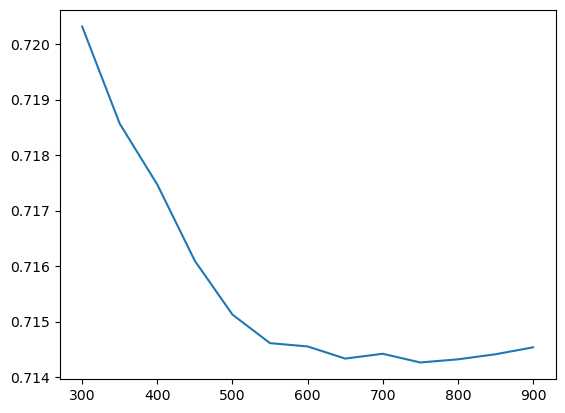

In [42]:
n_list = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]

loss_list = []

for n in n_list:

    param_grid = {
        'n_estimators': [n],
        'learning_rate': [0.05],
        'max_depth': [7],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0],
        'reg_alpha': [0.2],
        'reg_lambda': [0.2]
    }

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    # Fit the model
    grid_search.fit(data_train_cv, y_train)
    loss_list.append((-grid_search.best_score_)**0.5)

plt.clf()
plt.plot(n_list, loss_list)
plt.show()

In [43]:
# final prediction


final_mdl = XGBRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=800, subsample=0.8, gamma=0, reg_alpha=0.2, reg_lambda=0.1)
final_mdl.fit(data_train, y_train)




prediction = np.round(final_mdl.predict(data_test)).astype(int)

print(len(prediction))
print(len(ID))

output = pd.DataFrame({
    'id': ID,
    'price': prediction
})

output.to_csv('output_28.csv', index=False)

6727
6727
